In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing
import datetime
import time

In [2]:
np.random.seed(400)
np.seterr(over='raise');
plt.rcParams['figure.figsize'] = (15.0, 5.0)

In [3]:
class CIFAR_IMAGES:
    def __init__(self):
        self.label_size = 10
        self.image_size = 32 * 32 * 3
        #for one_hot_encoding
        self.label_encoder = preprocessing.LabelBinarizer()
        # file path of the images on your laptop
        self.filePath = 'Dataset/data_batch_1'
        self.unique_labels = []
        
    def load_labels(self, filePathLocal, keyToRead=b'label_names'):
        self.filePath = filePathLocal
        with open(filePathLocal, 'rb') as fileToOpen:
            dictUniqueLabels = pickle.load(fileToOpen, encoding='bytes')
            #dictUniqueLabels_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])
            #print(dictUniqueLabels.get(b'label_names'))
            #print(type(dictUniqueLabels[b'label_names'][0]))
            #<class 'bytes'>
            #[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
            # labels = class names of each image. we convert the values from bytes to string
            self.unique_labels = [u_lbl.decode('ascii') for u_lbl in dictUniqueLabels[keyToRead]]
            #print(unique_labels)
            #['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
            #print(type(self.unique_labels[0]))
            #<class 'str'>
    
    def load_batch(self, filePathLocal):
        # requires "import pickle"
        # filePathLocal=filepath for the the required batch of images
        with open(filePathLocal, 'rb') as fileToOpen:
            dictBatch = pickle.load(fileToOpen, encoding='bytes')
            # dictBatch.keys()
            # dictBatch_keys([b'batch_label', b'labels', b'data', b'filenames'])
        return dictBatch
    
    # below function corresponds to [X, Y, y] = LoadBatch(filename) in the assignment, 1st task.
    def load_batch_a1(self, filePathLocal):
        with open(filePathLocal, 'rb') as fileToOpen:
            dictBatch = pickle.load(fileToOpen, encoding='bytes')
            Y_one_hot_labels = self.label_encoder.fit_transform(dictBatch[b'labels'])
        #return [X, Y, y]
        return [np.divide(dictBatch[b'data'], 255).transpose(), Y_one_hot_labels.transpose(), np.array(dictBatch[b'labels'])]
    
    
    # dictBatchData is the dictionary having all info related to the images in the batch
    # dictBatch[b'data']=a numpy array with  having all data (b'data') information from the loaded batch
    # e.g. for the batch1, dictBatchData=(10000, 3072) matrix (row:image, Column:HxWxRGB binary))
    def show_images(self, dictBatchData):
        #import matplotlib.pyplot as plt
        fig, ax = plt.subplots(2,5) # 2, 5=?
        for i in range(2):
            for j in range(5):
                im  = dictBatchData[b'data'][5*i+j,:].reshape(32,32,3, order='F') # why do we use order='F'??
                #sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
                sim = np.divide(im, 255)
                # rotate to the counter-clockwise 90 degrees for 3 times because images are provided rotated once
                sim = np.rot90(sim, k=3)
                # below does the rotation, too
                #sim = sim.transpose(1,0,2)
                
                ax[i][j].imshow(sim, interpolation='nearest')
                ax[i][j].set_title("img_" + str(5*i+j) + ": " + self.unique_labels[dictBatchData[b'labels'][5*i+j]])
                ax[i][j].axis('off')
        plt.show()
        
    def show_images_random(self, dictBatchData, n_row = 2, n_column = 5):
        #import matplotlib.pyplot as plt
        fig, ax = plt.subplots(n_row, n_column)
        total_images = n_row * n_column
        for plot_i, img_i in enumerate(np.random.choice(dictBatchData[b'data'].shape[0], total_images, replace=False)):
                im  = dictBatchData[b'data'][img_i,:].reshape(32,32,3, order='F')
                sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
                # better to use above calculation for the normalization since the values might not always 
                # be regular RGB (in 0-255 range)
                #sim = np.divide(im, 255)
                # rotate to the counter-clockwise 90 degrees for 3 times because images are provided rotated once
                sim = np.rot90(sim, k=3)
                # below does the rotation, too
                #sim = sim.transpose(1,0,2)
                
                plt.subplot(n_row, n_column, plot_i+1)
                plt.imshow(sim, interpolation='gaussian')
                plt.title("img_" + str(img_i) + ": " + self.unique_labels[dictBatchData[b'labels'][img_i]])
                plt.axis('off')
        plt.show()
    
    def show_images_array(self, W, n_row = 2, n_column = 5):
        # W is the weight array of size Cxd = 10x3072
        fig, ax = plt.subplots(n_row, n_column)
        for plot_i, img_i in enumerate(W):
            im  = img_i.reshape(32,32,3, order='F')
            sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))

            plt.subplot(n_row, n_column, plot_i+1)
            plt.imshow(sim, interpolation='gaussian')
            plt.title("img_" + str(plot_i))
            plt.axis('off')
        plt.show()
        
        
    """ Used to transfer a python model to matlab """
    def save_as_mat(data, name="model"):
        #import scipy.io as sio
        sio.savemat(name+'.mat',{name:b})
        

In [4]:
class COMPUTATIONS:
    def softmax(self, s):
        """ Standard definition of the softmax function """
        return np.exp(s) / np.sum(np.exp(s), axis=0)
    
    def ComputeGradsNum(self, X, Y, P, W, b, lamda, h=1e-6):
        """ Converted from matlab code """
        K = W.shape[0]
        d = X.shape[0]

        grad_W = np.zeros(W.shape)
        grad_b = np.zeros((K, 1))

        c = self.ComputeCost(Y, X, b, W, lamda);
        #c = ComputeCost(X, Y, W, b, lamda);  # provided by canvas
        #c = ComputeCost_2(Y, X, b, W, lambda)

        for i in range(len(b)):
            b_try = np.array(b)
            b_try[i] += h
            c2 = self.ComputeCost(Y, X, b_try, W, lamda)
            # # provided by canvas
            #c2 = ComputeCost_2(Y, X, b_try, W, lambda)
            grad_b[i] = (c2-c) / h

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = np.array(W)
                W_try[i,j] += h
                #c2 = ComputeCost(X, Y, W_try, b, lamda) # provided by canvas
                c2 = self.ComputeCost(Y, X, b, W_try, lamda)
                #c2 = ComputeCost_2(Y, X, b, W_try, lambda)
                grad_W[i,j] = (c2-c) / h

        return [grad_W, grad_b]

    def ComputeGradsNumSlow(self, X, Y, P, W, b, lamda, h=1e-6):
        """ Converted from matlab code """
        K = W.shape[0]
        d = X.shape[0]

        grad_W = np.zeros(W.shape);
        grad_b = np.zeros((K, 1));

        for i in range(len(b)):
            b_try = np.array(b)
            b_try[i] -= h
            c1 = self.ComputeCost(Y, X, b_try, W, lamda)
            #c1 = ComputeCost(X, Y, W, b_try, lamda) # provided by canvas

            b_try = np.array(b)
            b_try[i] += h
            c2 = self.ComputeCost(Y, X, b_try, W, lamda)
            #c2 = ComputeCost(X, Y, W, b_try, lamda) # provided by canvas

            grad_b[i] = (c2-c1) / (2*h)

        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W_try = np.array(W)
                W_try[i,j] -= h
                c1 = self.ComputeCost(Y, X, b, W_try, lamda)
                #c1 = ComputeCost(X, Y, W_try, b, lamda) # provided by canvas

                W_try = np.array(W)
                W_try[i,j] += h
                c2 = self.ComputeCost(Y, X, b, W_try, lamda) 
                #c2 = ComputeCost(X, Y, W_try, b, lamda) # provided by canvas

                grad_W[i,j] = (c2-c1) / (2*h)

        return [grad_W, grad_b]
    
    def EvaluationClassifier(self, X, W, b):
        # W = (Kxd) size, randomly initialized weights
        # X = each column of X corresponds to an image and it has size (dxn) >> here n will be smaller since 
        # it will be selected as subset of images n=100 can be selected
        # b = (Kx1) size, randomly initialized bias
        #print('b.shape: ' + str(b.shape))
        #print('X.shape: ' + str(X.shape))
        b_broadcast = np.tile(b, (1, X.shape[1]))
        #b_broadcast = np.broadcast_to(b, (b.shape[0], X.shape[1]))
        #print('b_broadcast.shape: ' + str(b_broadcast.shape))
        s = np.dot(W, X) + b_broadcast
        # p = probabilities of each class to the corresponding images
        p = self.softmax(s)
        return p
    
    def ComputeCost(self, Y_matrix, P, W, lambda_cost):
        # Y_matrix = ground_truth_labels_matrix
        # P = probabilities
        cross_entropy_loss = -np.log(np.dot(Y_matrix.transpose(), P))
        sum_cross_entropy_loss = np.trace(cross_entropy_loss)
        N = Y_matrix.shape[1]
        return sum_cross_entropy_loss/N + lambda_cost*np.power(W, 2).sum() 
    
    def ComputeCost(self, Y_matrix, X, b, W, lambda_cost):
        b_broadcast = np.tile(b, (1, X.shape[1]))
        s = np.dot(W, X) + b_broadcast
        # P = probabilities of each class to the corresponding images
        P = self.softmax(s)
        
        # Y_matrix = ground_truth_labels_matrix
        # P = probabilities
        cross_entropy_loss = -np.log(np.dot(Y_matrix.transpose(), P))
        sum_cross_entropy_loss = np.trace(cross_entropy_loss)
        N = Y_matrix.shape[1]
        return sum_cross_entropy_loss/N + lambda_cost*np.power(W, 2).sum()
    
    def ComputeAccuracy(self, k, y):
        # k = predictions=the label with the max(probability) = Nx1
        # y = ground_truth_labels = Nx1
        # N = batch_length = number of images used
        N = k.shape[0]
        return np.sum(k == y)/N
    
    def ComputeGradients(self, Y, P, X, lambda_cost, W):
        # Y = ground_truth_labels_matrix
        # P = probabilities
        # X = image data
        G = - np.subtract(Y, P)
        N = Y.shape[1]

        dL_dW = np.divide(np.dot(G, X.transpose()), N)
        dL_dB = np.divide(np.sum(G, axis=1), N)

        # grad_W = dJ_dW    ...   grad_b = dJ_db
        grad_W = dL_dW + 2 * lambda_cost * W
        grad_b = dL_dB
        return [grad_W, grad_b]
    
    def MiniBatchGD(self, X, Y, GDparams, W, b, lambda_cost):
        P = self.EvaluationClassifier(X, W, b)

        n_batch = GDparams[0]  # e.g. n_batch=100
        eta = GDparams[1]      # e.g. eta=0.001
        n_epocs = GDparams[2]    # e.g. epocs=20
        
        [grad_W, grad_b] = self.ComputeGradients(Y, P, X, lambda_cost, W)
        
        Wstar = W - eta * grad_W
        bstar_m = b - eta * grad_b
        bstar = bstar_m[:, :1]
        
        return [Wstar, bstar]
    
    def CostCalculations(self, GDparams, TrainData, ValidationData, TestData):
        #GDparams = [n_batch, eta, n_epocs, lambda_cost]
        #TrainData = [train_X_normalized, train_Y, train_y]
        #ValidationData = [validation_X_normalized, validation_Y, validation_y]
        
        lambda_cost = GDparams[3] # lambda_cost=0; lambda_cost=0; lambda_cost=0.1; lambda_cost=1; 
        n_epocs = GDparams[2] # n_epocs=40; n_epocs=40; n_epocs=40; n_epocs=40;
        
        eta = GDparams[1] # eta=0.1; eta=0.001; eta=0.001; eta=0.001;
        # n_batch: the size of the batch, in other words, the number of images in each batch
        n_batch = GDparams[0] # n_batch=100; n_batch=100; n_batch=100; n_batch=100;
        
        train_X_normalized = TrainData[0]
        train_Y = TrainData[1]
        train_y = TrainData[2]
        
        validation_X_normalized = ValidationData[0]
        validation_Y = ValidationData[1]
        validation_y = ValidationData[2]
        
        test_X_normalized = TestData[0]
        test_Y = TestData[1]
        test_y = TestData[2]
        
        K = 10  # number of labels/classes
        d = 3072 # number of dimensions of an image 32x32x3
        mu, sigma = 0, 0.01 # mean and standard deviation
        W = np.random.normal(mu, sigma, (K, d))
        b = np.random.normal(mu, sigma, (K, 1))

        # J_epocs = cost per epoch
        J_epocs_train = np.zeros(n_epocs)
        J_epocs_validation = np.zeros(n_epocs)
        # Accuracy_epocs = accuracy per epoch
        Accuracy_epocs_train = np.zeros(n_epocs)
        Accuracy_epocs_validation = np.zeros(n_epocs)

        start_time = datetime.datetime.now()
        total_batch = int(train_X_normalized.shape[1] / n_batch) # how many batches we will have
        # i.e if n_batch=10 and we have 200 images, then we will have 20 batches each having 10 images in it
        for e in range(n_epocs):
            #print('e: ' + str(e))
            for batch in range(total_batch):
                #print('batch: ' + str(batch))
                index_list = list(range(batch * 100, (batch+1) * 100))
                # shuffling the indexes (so image samples) of the selected batch
                np.random.shuffle(index_list)
                X_batch = train_X_normalized[:, index_list]
                Y_batch = train_Y[:, index_list]

                [W, b] = self.MiniBatchGD(X_batch, Y_batch, GDparams, W, b, lambda_cost)

            P_train = self.EvaluationClassifier(train_X_normalized, W, b)
            k_train = np.argmax(P_train, axis=0)  
            A_train = self.ComputeAccuracy(k_train, train_y)
            Accuracy_epocs_train[e] = A_train

            P_validation = self.EvaluationClassifier(validation_X_normalized, W, b)
            k_validation = np.argmax(P_validation, axis=0)  
            A_validation = self.ComputeAccuracy(k_validation, validation_y)
            Accuracy_epocs_validation[e] = A_validation

            J_train = self.ComputeCost(train_Y, train_X_normalized, b, W, lambda_cost)
            J_epocs_train[e] = J_train

            J_validation = self.ComputeCost(validation_Y, validation_X_normalized, b, W, lambda_cost)
            J_epocs_validation[e] = J_validation
            
        P_test = self.EvaluationClassifier(test_X_normalized, W, b)
        k_test = np.argmax(P_test, axis=0)
        acc_test = self.ComputeAccuracy(k_test, test_y)
        print("\nTest data final accuracy: "+ str(round(acc_test*100, 4)) + "%")
        
        self.Plot_Train_Validation_Cost_Accurracy(J_epocs_train, J_epocs_validation, Accuracy_epocs_train, Accuracy_epocs_validation)
        
        cifar = CIFAR_IMAGES()
        cifar.show_images_array(W)
        #print(W.shape)
        #print(W)
        
        end_time = datetime.datetime.now()
        print("Calculation time: "+ str(end_time - start_time))
        return W, b
    
    def Plot_Train_Validation_Cost_Accurracy(self, Cost_Train, Cost_Validation, Acc_Train, Acc_Validation):
        plt.subplot(1,2,1)
        plt.plot(Cost_Train, 'g-', label='Train')
        plt.plot(Cost_Validation, 'r-', label='Validation')
        plt.title('Cost Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Cost')
        plt.legend()
        plt.grid('on')
        
        plt.subplot(1,2,2)
        plt.plot(Acc_Train, 'g-', label='Train')
        plt.plot(Acc_Validation, 'r-', label='Validation')
        plt.title('Accuracy Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid('on')

In [5]:
class Assignment1:
    def __init__(self):
        self.filePathLocal_labels = 'Dataset/batches.meta'
        self.filePathLocal_batch = 'Dataset/data_batch_1'
        self.filePathLocal_data_TRAIN = 'Dataset/data_batch_1'
        self.filePathLocal_data_VALIDATION = 'Dataset/data_batch_2'
        self.filePathLocal_data_TEST = 'Dataset/test_batch'
        self.K = 10  # number of labels/classes
        self.d = 3072 # number of dimensions of an image 32x32x3
        self.mu, self.sigma = 0, 0.01 # mean and standard deviation
        self.batch_length = 100 # N=100 samples picked as a subset
        self.lambda_cost = 0
        self.h = 1e-6
        self.eps = 1e-6
        
    def test_batch_images(self, cifar_batch):
        # show random images from the provided batch
        cifar_batch.load_labels(self.filePathLocal_labels)
        train_img = cifar_batch.load_batch(self.filePathLocal_batch)

        #cifar_batch.show_images(train_img)
        # ****
        # the below function (show_images_random) takes longer than the upper function (show_images)
        cifar_batch.show_images_random(train_img)
    
    def Task1(self, cifar_batch):
        # Top-level: Read in and store the training, validation and test data.
        # cifar_batch = CIFAR_IMAGES()
        [self.train_X, self.train_Y, self.train_y] = cifar_batch.load_batch_a1(self.filePathLocal_data_TRAIN)
        [self.validation_X, self.validation_Y, self.validation_y] = cifar_batch.load_batch_a1(self.filePathLocal_data_VALIDATION)
        [self.test_X, self.test_Y, self.test_y] = cifar_batch.load_batch_a1(self.filePathLocal_data_TEST)
    
    def Task2(self):
        # Top-level: Compute the mean and standard deviation vector for the training data and then normalize the 
        # training, validation and test data w.r.t. these mean and standard deviation vectors.
        mean_train_X = self.train_X.mean(axis=1)
        mean_train_X_broadcast = np.tile(mean_train_X, (10000, 1))
        std_train_X = self.train_X.std(axis=1)
        std_train_X_broadcast = np.tile(std_train_X, (10000, 1))
        #plt.hist(std_train_X)

        # http://cs231n.github.io/python-numpy-tutorial/#numpy-broadcasting
        self.train_X_normalized = (self.train_X - mean_train_X_broadcast.transpose())/std_train_X_broadcast.transpose()
        self.validation_X_normalized = (self.validation_X - mean_train_X_broadcast.transpose())/std_train_X_broadcast.transpose()
        self.test_X_normalized = (self.test_X - mean_train_X_broadcast.transpose())/std_train_X_broadcast.transpose()
        
    def Task2_test(self):
        print("Train_X_Normalized: " + self.train_X_normalized.mean(axis=1))
        print("Train_X_Normalized: " + \
              str(sum(self.train_X_normalized.mean(axis=1))/len(self.train_X_normalized.mean(axis=1))))
        print(str(max(self.train_X_normalized.mean(axis=1))))
        print(str(min(self.train_X_normalized.mean(axis=1))))
        #print(mean_train_X_broadcast.shape)
    
    def Task3(self):
        # Top-Level: After reading in and pre-processing the data, you can initialize the parameters of the model 
        # W and b as you now know what size they should be. W has size Kxd and b is Kx1. Initialize each entry to have 
        # Gaussian random values with zero mean and standard deviation .01. 
        # You should use the Matlab function randn to create this data.
        self.W = np.random.normal(self.mu, self.sigma, (self.K, self.d))
        self.b = np.random.normal(self.mu, self.sigma, (self.K, 1))
        
    def Task4(self, comp):
        # comp = COMPUTATIONS()
        # Top-level: Check the function runs on a subset of the training data given a random initialization of the 
        # network's parameters: P = EvaluateClassifier(trainX(:, 1:100), W, b)
        self.train_X_batch = self.train_X[:, 0:self.batch_length]
        self.P_batch = comp.EvaluationClassifier(self.train_X_batch, self.W, self.b)
        self.train_Y_batch = self.train_Y[:, 0:self.batch_length]
        self.train_y_batch = self.train_y[0:self.batch_length]
        #print(P.shape) # (10, 100) (K, n)

    def Task5(self, comp):
        # comp = COMPUTATIONS()
        # Write the function that computes the cost function given by equation
        # J = ComputeCost(X, Y, W, b, lambda)
        # J = cost = ComputeCost(X, Y, W, b, lambda) >> in the assignment document.
        # ComputeCost(Y, P, W, lambda) >> we use only those since X, b have already been used to calculate P
        #J = comp.ComputeCost(train_Y_batch, P_batch, W, lambda_cost)
        # b=(10, 1)    ...   W=(10, 3072)    ...  X=(3072, 100)
        # b_broadcast_test = np.tile(b, (1, train_X_batch.shape[1]))  >> b_broadcast_test.shape=(10, 100)        
        self.J = comp.ComputeCost(self.train_Y_batch, self.train_X_batch, self.b, self.W, self.lambda_cost)

    def Task6(self, comp):
        # comp = COMPUTATIONS()
        # Write a function that computes the accuracy of the network's predictions given by equation(4) on a set of data.
        # k = predictions
        self.k = np.argmax(self.P_batch, axis=0)
        self.acc = comp.ComputeAccuracy(self.k, self.train_y_batch)
        print("Accuracy (Task6): " + str(self.acc))  # acc = 0.13
        
    def Task7(self, comp):
        # comp = COMPUTATIONS()
        # Write the function that evaluates, for a mini-batch, the gradients of the cost function w.r.t. W and b, 
        # that is equations (10, 11).
        start_time = datetime.datetime.now()
        [self.grad_W, self.grad_b] = comp.ComputeGradients(self.train_Y_batch, self.P_batch, self.train_X_batch, self.lambda_cost, self.W)
        [self.grad_W_num, self.grad_b_num] = comp.ComputeGradsNum(self.train_X_batch, self.train_Y_batch, self.P_batch, self.W, self.b, self.lambda_cost, self.h)
        end_time = datetime.datetime.now()
        print("Calculation time: "+ str(end_time - start_time))
        
    def Task7_test1(self):
        #print(train_X_batch.shape)
        #print(grad_W_num.shape)
        #print(grad_b_num.shape) # grad_b_num.shape=(10, 1)     grad_b.shape=(10,)
        #print("sum_grad_b_difference = " + str(np.abs(grad_b - grad_b_num.transpose()).sum()))
        
        ######### W #######
        print("\ngrad_W_difference_MEAN = "+ str(np.abs(self.grad_W - self.grad_W_num).mean()))
        print("grad_W_difference_MIN = "+ str(np.abs(self.grad_W - self.grad_W_num).min()))
        print("grad_W_difference_MAX = "+ str(np.abs(self.grad_W - self.grad_W_num).max()))

        #print("sum_grad_W_difference = " + str(np.abs(grad_W - grad_W_num).sum()))

        print("\ngrad_W_MIN = " + str(np.min(np.abs(self.grad_W))))
        print("grad_W_num_MIN = " + str(np.min(np.abs(self.grad_W_num))))
        print("grad_W_MAX = " + str(np.max(np.abs(self.grad_W))))
        print("grad_W_num_MAX = " + str(np.max(np.abs(self.grad_W_num))))
        
        ######### b #######
        print("\ngrad_b_difference_MEAN = "+ str(np.abs(self.grad_b - self.grad_b_num.transpose()).mean()))
        print("grad_b_difference_MIN = "+ str(np.abs(self.grad_b - self.grad_b_num.transpose()).min()))
        print("grad_b_difference_MAX = "+ str(np.abs(self.grad_b - self.grad_b_num.transpose()).max()))
        print("\ngrad_b_MIN = " + str(min(np.abs(self.grad_b))))
        print("grad_b_num_MIN = " + str(min(np.abs(self.grad_b_num))))
        print("\ngrad_b_MAX = " + str(max(np.abs(self.grad_b))))
        print("grad_b_num_MAX = " + str(max(np.abs(self.grad_b_num))))
            
    def Task7_test2(self):
        diff2_W = np.abs(self.grad_W - self.grad_W_num)
        sum2_W = np.abs(self.grad_W) + np.abs(self.grad_W_num)
        
        eps2_W = np.full_like(sum2_W, 1e-6)
        #print(eps2)
        #print(eps2.shape)

        sum2_W_max = np.zeros_like(sum2_W)

        for r in range(sum2_W.shape[0]):
            for c in range(sum2_W.shape[1]):
                if(sum2_W[r, c] > eps2_W[r, c]):
                    sum2_W_max[r, c] = sum2_W[r, c]
                else:
                    sum2_W_max[r, c] = eps2_W[r, c]
     
        self.gradient_W_error_check_2 = diff2_W/sum2_W_max
        
        print("gradient_W_error_check_2-MAX: " + str(np.max(self.gradient_W_error_check_2)))
        print("gradient_W_error_check_2-MIN: " + str(np.min(self.gradient_W_error_check_2)))
        print("gradient_W_error_check_2-MEAN: " + str(np.mean(self.gradient_W_error_check_2)))
        print("gradient_W_error_check_2-STD: " + str(np.std(self.gradient_W_error_check_2)))
        #print(sum2_W_max)
        #print(np.max(sum2_W_max))
        #print(np.min(sum2_W_max))

        #self.grad_b_reshape = self.grad_b.reshape(self.grad_b_num[0], self.grad_b_num[1])
        
        diff2_b = np.abs(self.grad_b - self.grad_b_num.transpose())
        sum2_b = np.abs(self.grad_b) + np.abs(self.grad_b_num.transpose())
        
        eps2_b = np.full_like(sum2_b, 1e-6)
        
        sum2_b_max = np.zeros_like(sum2_b)
        
        self.sum2_b_test = sum2_b
        self.eps2_b_test = eps2_b
        
        for r in range(sum2_b.shape[1]):
            if(sum2_b[0][r] > eps2_b[0][r]):
                sum2_b_max[0][r] = sum2_b[0][r]
            else:
                sum2_b_max[0][r] = eps2_b[0][r]

        #print(sum2_b_max)
        #print(np.max(sum2_b_max))
        #print(np.min(sum2_b_max))

        self.gradient_b_error_check_2 = diff2_b/sum2_b_max
 
        print("\ngradient_b_error_check_2-MAX: " + str(np.max(self.gradient_b_error_check_2)))
        print("gradient_b_error_check_2-MIN: " + str(np.min(self.gradient_b_error_check_2)))
        print("gradient_b_error_check_2-MEAN: " + str(np.mean(self.gradient_b_error_check_2)))
        print("gradient_b_error_check_2-STD: " + str(np.std(self.gradient_b_error_check_2)))
        
        '''
        self.gradient_W_error_check_2 = np.abs(self.grad_W[0, 0] - \
                                          self.grad_W_num[0, 0])/max(self.eps, np.abs(self.grad_W[0, 0]) +\
                                                                               np.abs(self.grad_W_num[0, 0]))
        print("\ngradient_W_error_check_2: " + str(self.gradient_W_error_check_2))
        
        self.gradient_b_error_check_2 = np.abs(self.grad_b[0] - \
                                          self.grad_b_num[0])/max(self.eps, \
                                                            np.abs(self.grad_b[0]) + np.abs(self.grad_b_num[0]))
        print("\ngradient_b_error_check_2: " + str(self.gradient_b_error_check_2))
        '''
    
    def Task8(self, comp, GDparams):
        # Once you have the gradient computations debugged you are now ready to write the code to perform the mini-batch 
        # gradient descent algorithm to learn the network's parameters
        #comp = COMPUTATIONS()
        #GDparams = [n_batch, eta, n_epocs, lambda_cost] 
        TrainData = [self.train_X_normalized, self.train_Y, self.train_y]
        ValidationData = [self.validation_X_normalized, self.validation_Y, self.validation_y]
        TestData = [self.test_X_normalized, self.test_Y, self.test_y]
        
        print("************ CostCalculations ************\n")
        print("GDparams: [n_batch={}, eta={}, n_epocs={}, lambda_cost={}]".\
              format(GDparams[0], GDparams[1], GDparams[2], GDparams[3]))
        
        W_final, b_final = comp.CostCalculations(GDparams, TrainData, ValidationData, TestData)
        return W_final, b_final
    

In [ ]:
asgn1 = Assignment1()
cifar_batch1 = CIFAR_IMAGES()
asgn1.test_batch_images(cifar_batch1)

In [ ]:
#### TASK - 1 ###
# Top-level: Read in and store the training, validation and test data.
asgn1.Task1(cifar_batch1)

In [ ]:
#### TASK - 2 ###
# Top-level: Compute the mean and standard deviation vector for the training data and then normalize the 
# training, validation and test data w.r.t. these mean and standard deviation vectors.
asgn1.Task2()
asgn1.Task2_test()

In [ ]:
#### TASK - 3 ###
# Top-Level: After reading in and pre-processing the data, you can initialize the parameters of the model 
# W and b as you now know what size they should be. W has size Kxd and b is Kx1. Initialize each entry to have 
# Gaussian random values with zero mean and standard deviation .01. 
# You should use the Matlab function randn to create this data.
asgn1.Task3()

In [ ]:
#### TASK - 4 ###
# Top-level: Check the function runs on a subset of the training data given a random initialization of the 
# network's parameters: P = EvaluateClassifier(trainX(:, 1:100), W, b)
comp1 = COMPUTATIONS()
asgn1.Task4(comp1)

In [ ]:
#### TASK - 5 ###
# Write the function that computes the cost function given by equation
# J = ComputeCost(X, Y, W, b, lambda)
asgn1.Task5(comp1)

In [ ]:
#### TASK - 6 ###
# Write a function that computes the accuracy of the network's predictions given by equation(4) on a set of data.
# k = predictions
asgn1.Task6(comp1)

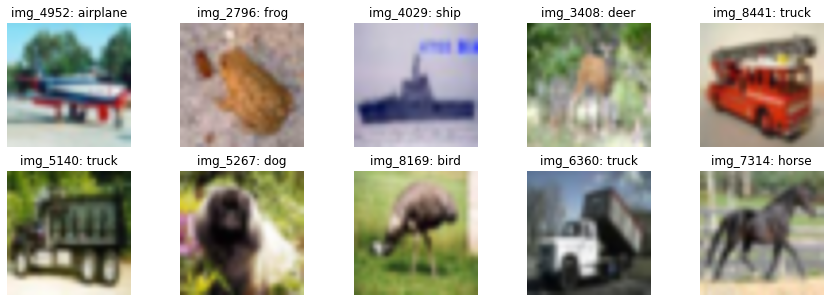

Accuracy (Task6): 0.08
Calculation time: 0:00:29.449437


In [6]:
#### TASK - 7 ###
# Write the function that evaluates, for a mini-batch, the gradients of the cost function w.r.t. W and b, 
# that is equations (10, 11).

asgn1 = Assignment1()
cifar_batch1 = CIFAR_IMAGES()
asgn1.test_batch_images(cifar_batch1)

asgn1.Task1(cifar_batch1)
asgn1.Task2()
#asgn1.Task2_test()
asgn1.Task3()
comp1 = COMPUTATIONS()
asgn1.Task4(comp1)
asgn1.Task5(comp1)
asgn1.Task6(comp1)

asgn1.Task7(comp1)

In [7]:
asgn1.Task7_test1()


grad_W_difference_MEAN = 1.1744294772342884e-08
grad_W_difference_MIN = 4.2462113079150265e-09
grad_W_difference_MAX = 2.0602097774297112e-08

grad_W_MIN = 2.6074914276936644e-07
grad_W_num_MIN = 2.7267077484793845e-07
grad_W_MAX = 0.06195850560934546
grad_W_num_MAX = 0.06195849211465543

grad_b_difference_MEAN = 4.485301018791743e-08
grad_b_difference_MIN = 3.3935816448615874e-08
grad_b_difference_MAX = 5.488295274670707e-08

grad_b_MIN = 0.0045187974034357455
grad_b_num_MIN = [0.00451885]

grad_b_MAX = 0.07088109784271754
grad_b_num_MAX = [0.07088115]


In [8]:
asgn1.Task7_test2()

gradient_W_error_check_2-MAX: 0.011921632078572001
gradient_W_error_check_2-MIN: 8.468693465709592e-08
gradient_W_error_check_2-MEAN: 3.7668925332927018e-06
gradient_W_error_check_2-STD: 9.124804643697527e-05

gradient_b_error_check_2-MAX: 5.594272526021969e-06
gradient_b_error_check_2-MIN: 3.4259577097674394e-07
gradient_b_error_check_2-MEAN: 1.6819530245468294e-06
gradient_b_error_check_2-STD: 1.6728861311950061e-06


In [9]:
#### TASK - 8 ###
# Once you have the gradient computations debugged you are now ready to write the code to perform the mini-batch 
# gradient descent algorithm to learn the network's parameters
asgn1_task8 = Assignment1()
cifar_batch1_task8 = CIFAR_IMAGES()
comp_task8 = COMPUTATIONS()

asgn1_task8.Task1(cifar_batch1_task8)
asgn1_task8.Task2()
asgn1_task8.Task3()

#GDparams = [n_batch, eta, n_epocs, lambda_cost]: 
GDparams_1 = [100, 0.1, 40, 0]
GDparams_2 = [100, 0.001, 40, 0]
GDparams_3 = [100, 0.001, 40, 0.1]
GDparams_4 = [100, 0.001, 40, 1]


************ CostCalculations ************

GDparams: [n_batch=100, eta=0.1, n_epocs=40, lambda_cost=0]

Test data final accuracy: 25.8%


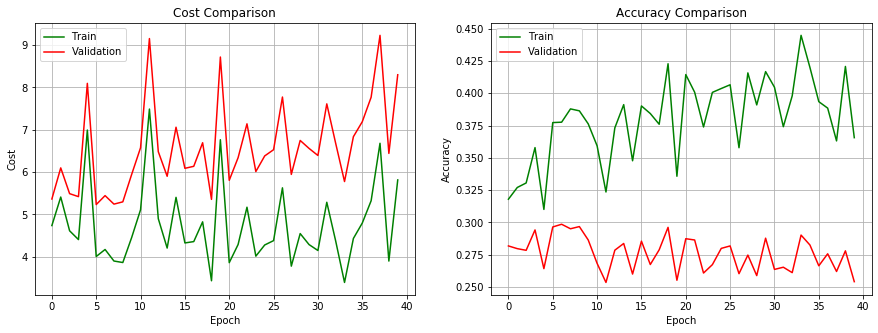

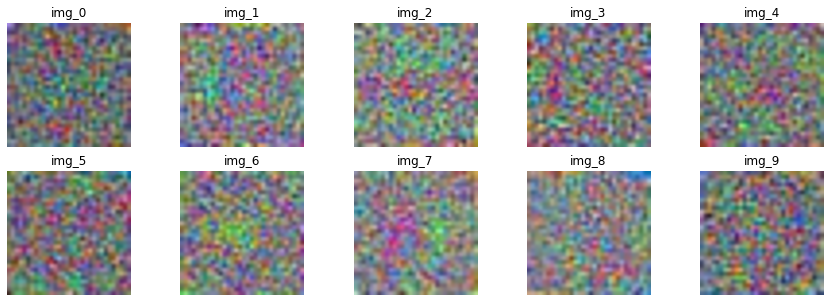

Calculation time: 0:01:01.165156


In [10]:
W_1, b_1 = asgn1_task8.Task8(comp_task8, GDparams_1)

************ CostCalculations ************

GDparams: [n_batch=100, eta=0.001, n_epocs=40, lambda_cost=0]

Test data final accuracy: 38.87%


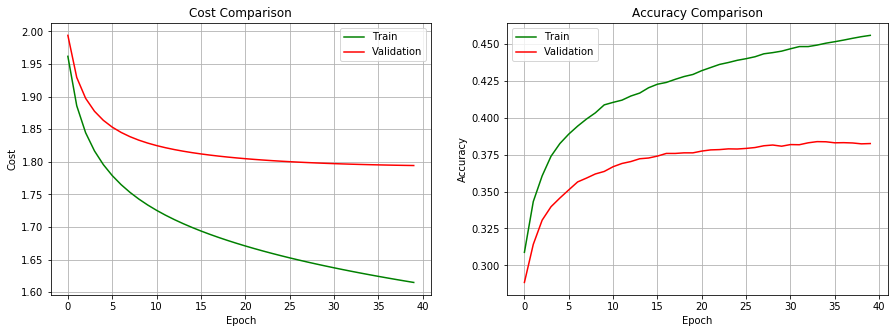

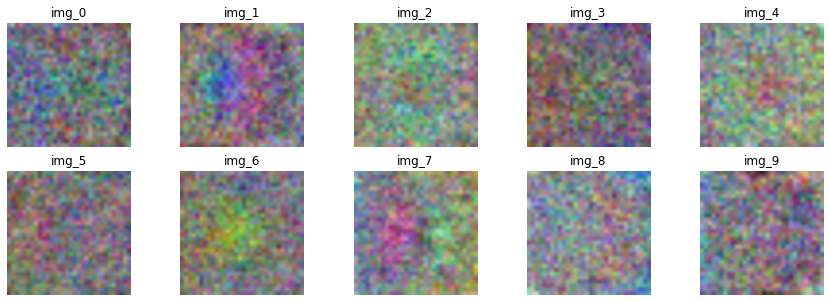

Calculation time: 0:01:01.390155


In [11]:
W_2, b_2 = asgn1_task8.Task8(comp_task8, GDparams_2)

************ CostCalculations ************

GDparams: [n_batch=100, eta=0.001, n_epocs=40, lambda_cost=0.1]

Test data final accuracy: 39.17%


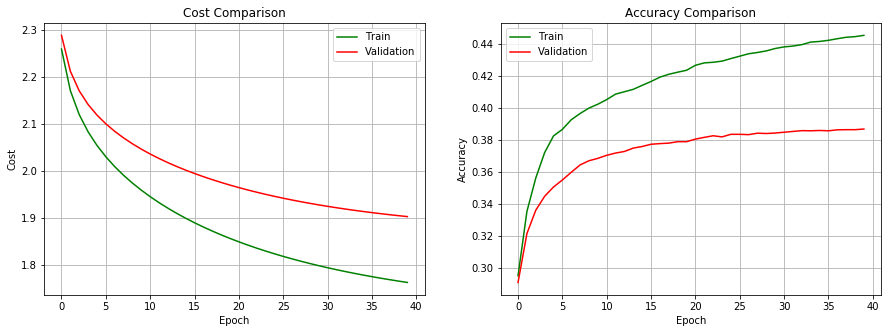

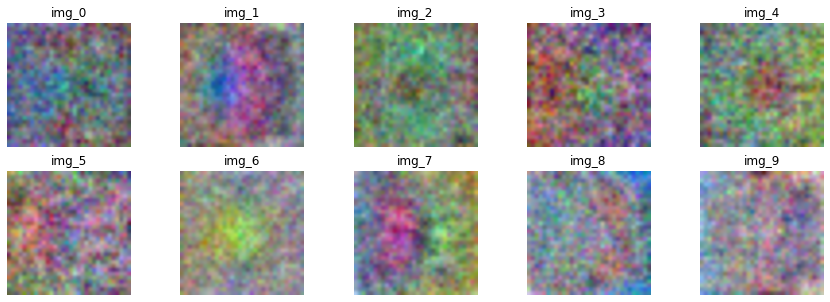

Calculation time: 0:01:03.495882


In [12]:
W_3, b_3 = asgn1_task8.Task8(comp_task8, GDparams_3)

************ CostCalculations ************

GDparams: [n_batch=100, eta=0.001, n_epocs=40, lambda_cost=1]

Test data final accuracy: 37.42%


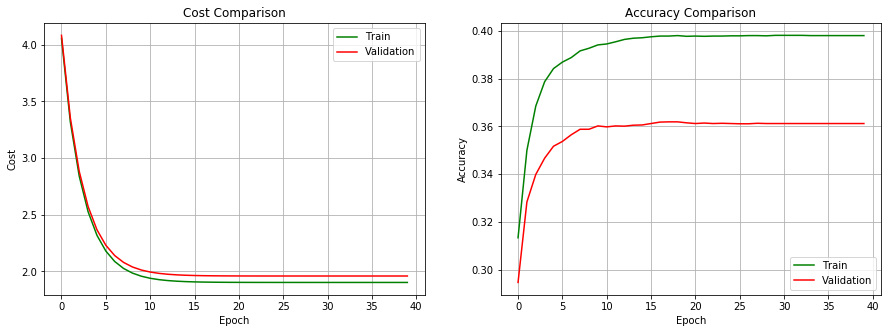

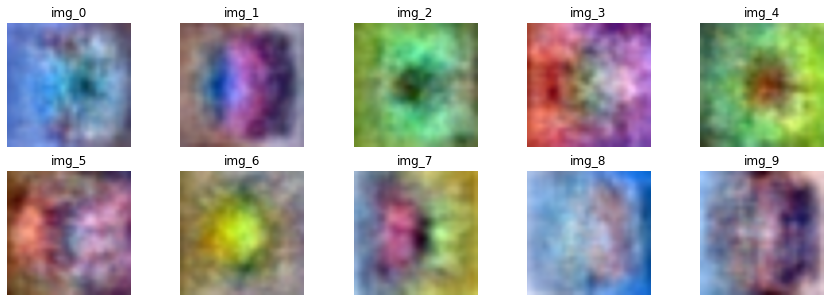

Calculation time: 0:01:00.652369


In [13]:
W_4, b_4 = asgn1_task8.Task8(comp_task8, GDparams_4)